In [94]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from helpers import *
from unet import *

In [95]:
#Setting size parameters of images
image_width = 256
image_height = 256

## Loading images and mask paths

In [96]:
image_filenames_train = []
 
 # creating a list of all files containing the word 'mask'

mask_files = glob('./input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif') 

for i in mask_files:
    image_filenames_train.append(i.replace('_mask',''))

print(mask_files[:10])

['./input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_19_mask.tif', './input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12_mask.tif']


## Plotting images and masks


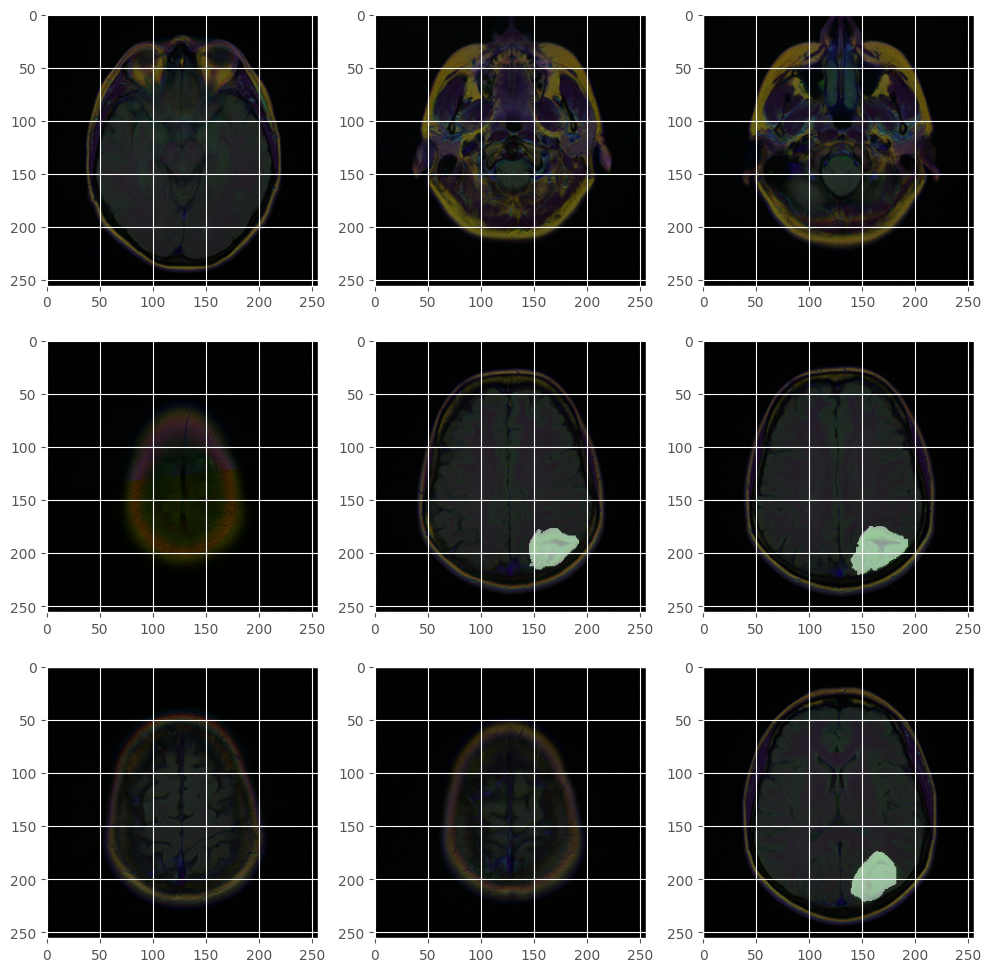

In [97]:
plot_from_image_path(3,3,image_filenames_train,mask_files)

## Separating data for training, validation, and testing

In [98]:
data = pd.DataFrame(data={'image_filenames':image_filenames_train,'masks':mask_files})

training_data, testing_data = train_test_split(data,test_size=0.05)

# We need also to separate data for validation and training from previous training data

training_data, validation_data = train_test_split(training_data,test_size=0.2)

print("Training data: ",training_data.shape)
print("Validation data: ", validation_data.shape)
print("Testing data: ",testing_data.shape)

Training data:  (2985, 2)
Validation data:  (747, 2)
Testing data:  (197, 2)


## Data generator, adjusting data 

In [99]:

# this function we are using for normalizing data and determinanting of diagnosis
# we will paint the image black if the patient doesn't have cancer


def adjustData(image, mask):
    image = image / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (image, mask)


def trainGenerator(batch_size, train_path, aug_dict, image_color_mode="grayscale",
                   mask_color_mode="grayscale", image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed)
    train_generator = zip(image_generator, mask_generator)
    for (image, mask) in train_generator:
        image, mask = adjustData(image, mask)
        yield (image, mask)


In [100]:
EPOCHS = 100,
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

In [101]:
train_generator_param = dict(rotation_range = 0.2,
                             width_shift_range=0.05,
                             height_shift_range = 0.05,
                             shear_range = 0.05,
                             zoom_range = 0.05,
                             horizontal_flip=True,
                             fill_mode = 'nearest')
train_gen = trainGenerator(training_data,BATCH_SIZE,train_generator_param,target_size=(image_height,image_width))
test_gen = trainGenerator(testing_data, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))
    
model = unet(input_size=(image_height, image_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(training_data) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(testing_data) / BATCH_SIZE)



TypeError: Inputs to a layer should be tensors. Got '<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x1079abd00>>' (of type <class 'method'>) as input for layer 'conv2d_4'.

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } )


In [ ]:
test_gen = trainGenerator(training_data, BATCH_SIZE, dict(), target_size=(image_height, image_width)  )

results = model.evaluate(test_gen, steps=len(training_data) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

In [ ]:
for i in range(20):
    index = np.random.ranint(1, len(training_data.index))
    img = cv2.imread(training_data['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (image_height, image_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(training_data['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()
